In [1]:
from hnn_core import jones_2009_model, simulate_dipole
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.viz import make_movie, plot_network
import matplotlib.pyplot as plt
from matplotlib import cm
from joblib import Parallel, delayed
import numpy as np
import seaborn as sns
from dask_jobqueue import SLURMCluster
import dask
from distributed import Client
import os
import sys
sns.set()
sns.set_style("white")
num_cores = 128

"""Reserve SLURM resources using Dask Distributed interface"""
 # Set up cluster and reserve resources
cluster = SLURMCluster(
    cores=32, processes=32, queue='shared', memory="256GB", walltime="00:30:00",
    job_extra=['-A csd403', '--nodes=1'], log_directory=os.getcwd() + '/slurm_out')

client = Client(cluster)
#client.cluster.scale(num_cores)
print(client.dashboard_link)

--No graphics will be displayed.


http://198.202.103.232:8787/status


In [2]:
net = jones_2009_model()

weights_ampa_p = {'L2_pyramidal': 5.4e-5, 'L5_pyramidal': 5.4e-5}
syn_delays_p = {'L2_pyramidal': 0.1, 'L5_pyramidal': 1.0}

weights_ampa_d = {'L2_pyramidal': 5.4e-5, 'L5_pyramidal': 5.4e-5}
syn_delays_d = {'L2_pyramidal': 5.0, 'L5_pyramidal': 5.0}

net.add_bursty_drive(
    'alpha_prox', tstart=50.0, tstart_std=50.0, burst_rate=10, burst_std=20, numspikes=2,
    spike_isi=10, n_drive_cells=10, location='proximal',
    weights_ampa=weights_ampa_p, synaptic_delays=syn_delays_p, event_seed=10)

net.add_bursty_drive(
    'alpha_dist', tstart=50.0, tstart_std=50.0, burst_rate=10, burst_std=20, numspikes=2,
    spike_isi=10, n_drive_cells=10, location='distal',
    weights_ampa=weights_ampa_d, synaptic_delays=syn_delays_d, event_seed=14)
dpl = simulate_dipole(net, tstop=710, record_vsec=True, dt=0.5)

joblib will run over 1 jobs
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn_movie/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.

In [3]:
for cell_type in net.cell_types.keys():
    net.cell_types[cell_type].update_end_pts()

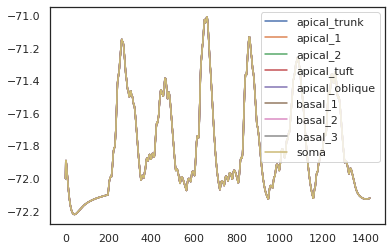

In [4]:
for section_name in net.cell_types['L5_pyramidal'].sections.keys():
    _ = plt.plot(net.cell_response.vsec[0][171]['soma'], label=section_name)
    
plt.legend()

In [5]:
def make_hnn_frame(net, dpl, t_idx, fig, ax1, ax2, ax3, ax4):
    plot_time = net.cell_response.times[t_idx]
    n_times = net.cell_response.times.shape[0]
    
    #net.cell_response.plot_spikes_hist(ax=ax1, show=False)
    l1 = ax1.axvline(plot_time, linewidth=2, color='k')

    # Plot 2
    #dpl[0].plot(ax=ax2, show=False)
    l2 = ax2.axvline(plot_time, linewidth=2, color='r')
  
    # Plot 3
    freqs = np.arange(6.0, 40.0, 1.0)
    #dpl[0].plot_tfr_morlet(freqs, n_cycles=7, ax=ax3, show=False)
    l3 = ax3.axvline(plot_time, linewidth=2, color='w')

    # Plot 4
    plot_network(net=net, ax=ax4, t_idx=t_idx, vmin=-72.3, vmax=-71)
    ax4.set_facecolor('k')
    n_rotations = 0.4 * (710 / 300)
    rot_pos = -100 + ((n_rotations / n_times) * t_idx * 360)
    ax4.view_init(15, -100)
    
    image_name = f'frame{t_idx}.png'
    fig.savefig(f'../network_images/{image_name}')
    l1.remove()
    l2.remove()
    l3.remove()
    ax4.clear()


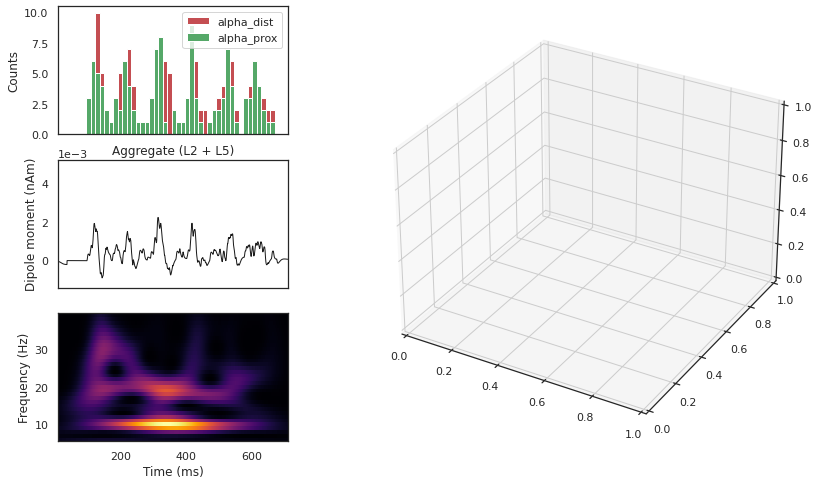

In [6]:
freqs = np.arange(6.0, 40.0, 1.0)
tmin, tmax = 10, 710

fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=1, colspan=1)
net.cell_response.plot_spikes_hist(ax=ax1, show=False)
ax1.set_xlim(tmin, tmax)
ax1.legend(loc='upper right')
ax1.set_xticks([])
ax1.set_xlabel(None)

ax2 = plt.subplot2grid((3, 3), (1, 0), rowspan=1, colspan=1)
dpl[0].plot(ax=ax2, show=False)
ax2.set_xlim(tmin, tmax)
ax2.set_xlabel(None)
ax2.set_xticks([])

ax3 = plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=1)
dpl[0].plot_tfr_morlet(freqs, n_cycles=7, ax=ax3, colorbar=False, show=False)
ax3.set_xlim(tmin, tmax)

ax4 = plt.subplot2grid((3, 3), (0, 1), rowspan=3, colspan=2, projection='3d')

In [ ]:
res_list= []
for t_idx, _ in enumerate(net.cell_response.times):
    res = dask.delayed(make_hnn_frame)(net, dpl, t_idx, fig, ax1, ax2, ax3, ax4)
    res_list.append(res)

# Run tasks
final_res = dask.compute(*res_list)

/home/ntolley/anaconda3/envs/hnn_movie/lib/python3.7/site-packages/distributed/worker.py:4158: UserWarning: Large object of size 25.23 MiB detected in task graph: 
  (<Network | 10 x 10 Pyramidal cells (L2, L5)
35 L2 ... xes3DSubplot:>)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [ ]:
Parallel(n_jobs=16)(delayed(make_hnn_frame)(
    net, dpl, t_idx, fig, ax1, ax2, ax3, ax4) for t_idx, _ in enumerate(net.cell_response.times))

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


In [4]:
images = [f'frame{t_idx}.png' for t_idx in range(net.cell_response.times.shape[0])]
make_movie('../network_images/', 'network_alpha_fixed_movie.mp4', images, fps=60)

In [ ]:
#os.system('scancel -u ntolley')